In [1]:
import random
import pprint
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      # P[s][a] = (prob, next_state, reward, is_done)
      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,45,63,64]
      no_down = lambda s: s in [23,24,25,44]
      no_left = lambda s: s in [44,36,55]
      no_right = lambda s: s in [32,42,52]

      #Barries in the path
      pit = lambda s: s in [13,62,41]
      wall = lambda s: s in [43,33,53,34,35,54]

      #Rewards of each state
      reward = 1.0 if is_done(s) else 0.0
#       reward = 10.0 if is_done(s) else 0.0 for the bonus part
      reward = -10.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1.0, s, reward, True)]
        P[s][RIGHT] = [(1.0, s, reward, True)]
        P[s][DOWN] = [(1.0, s, reward, True)]
        P[s][LEFT] = [(1.0, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -3.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -3.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -3.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -3.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[44]=1
    self.P = P

    super(GridworldEnv, self).__init__(nS, nA, P, isd)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,62,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,62,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,35,54]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()

Importing the necessary libraries 

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns
from itertools import combinations 
from collections import defaultdict
import itertools

In [69]:
moves_dict = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}

In [70]:
env = GridworldEnv()
env.reset()
env._render()

       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  


In [71]:
def generate_episode(env, policy, cap=np.inf):
    env.reset()
    s = np.argmax(env.isd)
    a = None
    r = None
    actions = []
    states = []
    rewards = []
    while cap > 0:
        states.append(s)
        a = np.random.choice(range(env.nA), p=policy[s])
        actions.append(a)
        s, r, done, info = env.step(a)
        rewards.append(r)
        cap -= 1
        if r == 1:
            break
            
    return states, actions, rewards

In [72]:
def occurred_previously(t, states, actions):
    for i in range(t):
        if states[t] == states[i] and actions[t] == actions[i]:
            return True
    return False

In [73]:
def plot_rewards(rewards, label, linewidth=1.0, alpha=1.0, minimum=None):
    plt.plot(rewards, label=label, linewidth=linewidth, alpha=alpha)
    plt.title('rewards per episodes ' + label)
    plt.xlabel('episode')
    plt.ylabel('reward')
    if minimum != None:
        plt.ylim(minimum, 2)

One of the most important matters with learning agents is determining the right value for hyper-parameters such as learning rate and epsilon. In each section representing one of the learning methods, you can see the hyper-parameters that I came across them by some experiments which were the most reasonable ones, although the value assigned to them can vary based on the problem in hand. On this ground, the choice of the softmax unit for choosing between actions regarding their surrounding q-values would be somehow more practical than the e-greedy or other strategies for doing so. The reason behind that is the act of these algorithms facing q-values. In the case of e-greedy, the best action is choosed based on the hyper-parameter epsilon that should be carefully determined. Plus, another issue with this algorithm is that it does not differentiate between the actions that are not the best ones and treat them uniformly. On other hand, the softmax unit actually choose actions based on the differences between the actual q-values. This way, the epsilon should not be incorporated and as a result of that, the more the distance between q-values, the more will be our confidence to choose certain action. Moreover, As opposed to e-greedy algorithm, this algorithm contrasts between other actions which are not the best ones considering their q-values. Intuitively, you can see that as incorporating a little more rationality into the act of choosing between actions. The performance of softmax unit invariably outperform the e-greedy.

In [74]:
def softmax(s, q, temperature=.1):
    p = np.zeros(env.nA)
    denom = sum([np.exp(q[s][a] / temperature) for a in range(env.nA)])
    p = [np.exp(q[s][a] / temperature) for a in range(env.nA)] / denom
    action = np.random.choice(range(env.nA), p=p)
    return action, p

def e_greedy(s, q):
    p = [epsilon / env.nA for a in range(env.nA)]
    p[np.argmax(q[s])] += 1 - epsilon
    action = np.random.choice(range(env.nA), p=p)
    return action, p

def e_greedy_policy(s, q):
    A = np.argmax(q[s])
    policy[s] = [epsilon / env.nA for a in range(env.nA)]
    policy[s][A] += 1 - epsilon
    return policy

In [75]:
def print_policies(policy):
    best_actions = np.argmax(policy, axis=-1)
    best_actions = np.array([moves_dict[m] for m in best_actions]).reshape((10, 10))
    print(best_actions)

As you would see in the rest of the notebook after adding the results of each method, this method has been called and the difference between different aspects of each method in terms of the reward gotten by the agents is assessed. Indeed, this method depicts the trajectory of all rewards in different episodes and compares them between two different learning strategy such as `Sarsa` and `Expected Sarsa`.

In [76]:
def plot_all_rewards(minimum=None):
    fig = plt.figure(figsize=(15, 10 * len(all_rewards) / 2))
    title = 'comparing '
    for mode in list(all_rewards.keys()):
        title += mode + ','
    fig.suptitle(title, fontsize=16)
    k = 1
    for i in range(len(all_rewards)):
        for j in range(i + 1, len(all_rewards)):
            ax = plt.subplot(int(np.ceil(len(list(combinations(range(len(all_rewards)), 2))) / 2)), 2, k)
            ax.plot(list(all_rewards.values())[i], label=list(all_rewards.keys())[i])
            ax.plot(list(all_rewards.values())[j], label=list(all_rewards.keys())[j])
            ax.set_xlabel('episodes')
            ax.set_ylabel('rewards')
            if minimum != None:
                ax.set_ylim(minimum, 5)
            plt.legend()
            k += 1

In [77]:
def make_epsilon_greedy_policy(Q, epsilon, nA):

    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon/nA
        best_action = np.argmax(Q[observation])
        A[best_action] += ( 1.0 - epsilon)
        return A

    return policy_fn

def make_softmax_policy(Q, temperature, nA):
    
    def policy_fn(observation):
        denom = sum([np.exp(Q[observation][a] / temperature) for a in range(nA)])
        p = [np.exp(Q[observation][a] / temperature) for a in range(nA)] / denom    
        return p
    return policy_fn
        

def chosen_action(Q):
    best_action = np.argmax(Q)
    return best_action


def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [78]:
all_rewards = dict()
all_times = dict()

On policy MC

In [118]:
discount_factor = 1
starting_epsilon = .2
num_episodes = 1000
epsilon = starting_epsilon
policy = np.ones(shape=(env.nS, env.nA)) / env.nA
q = np.zeros(shape=(env.nS, env.nA))
returns = [[[]for j in range(env.nA)] for i in range(env.nS)]
on_policy_mc_rewards = []
starting_time = time.time()
for i in range(num_episodes):
    states, actions, rewards = generate_episode(env, policy)
    on_policy_mc_rewards.append(sum(rewards))
    g = 0
    for t in range(len(states)-1,-1, -1):
        g = discount_factor * g + rewards[t]
        if not occurred_previously(t, states, actions):
            returns[states[t]][actions[t]].append(g)
            q[states[t]][actions[t]] = np.mean(returns[states[t]][actions[t]])
            A = np.argmax(q[states[t]])
            policy[states[t]] = [epsilon / env.nA for a in range(env.nA)]
            policy[states[t]][A] += 1 - epsilon
            policy = e_greedy_policy(states[t], q)
    if i%10 == 0:
        epsilon -= starting_epsilon / 101
    print("\rEpisode {}/{}.".format(i, num_episodes), end="")
    sys.stdout.flush()
end_time = time.time()
on_policy_time = end_time - starting_time

Episode 999/1000.

letting the agent wander after reaching the beach too.

time elapsed: 18.876364707946777


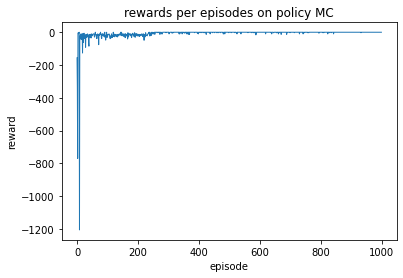

In [119]:
plot_rewards(on_policy_mc_rewards, label='on policy MC')
print('time elapsed: {}'.format(on_policy_time))
all_rewards['on policy mc'] = on_policy_mc_rewards
all_times['on policy mc'] = on_policy_time

Off Policy MC

In [56]:
print_policies(policy)

[['R' 'L' 'L' 'D' 'R' 'D' 'L' 'D' 'D' 'L']
 ['R' 'D' 'U' 'L' 'L' 'L' 'R' 'U' 'L' 'L']
 ['U' 'U' 'L' 'R' 'U' 'U' 'L' 'L' 'L' 'D']
 ['U' 'R' 'L' 'U' 'U' 'U' 'U' 'L' 'R' 'D']
 ['U' 'L' 'L' 'U' 'R' 'R' 'R' 'U' 'L' 'D']
 ['U' 'R' 'U' 'U' 'U' 'R' 'L' 'U' 'L' 'L']
 ['U' 'D' 'D' 'L' 'L' 'U' 'U' 'U' 'L' 'U']
 ['R' 'L' 'L' 'R' 'R' 'L' 'D' 'U' 'R' 'L']
 ['D' 'U' 'R' 'U' 'D' 'D' 'D' 'U' 'U' 'D']
 ['R' 'R' 'D' 'U' 'U' 'R' 'R' 'U' 'U' 'L']]


In [120]:
from collections import defaultdict
def random_policy(nA):
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn
    
def greedy_policy(Q):
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn
    
def mc_off_policy(env, num_episodes, behavior_policy, max_time=100, discount_factor=1.0):
    Q = defaultdict(lambda:np.zeros(env.action_space.n))
    C = defaultdict(lambda:np.zeros(env.action_space.n))

    target_policy = greedy_policy(Q)
    episode_rewards = []

    starting_time = time.time()
    
    for i_episode in range(1, num_episodes+1):
        
        temp_policy = np.zeros(shape=(env.nS, env.nA))
        for t_state in range(env.nS):
            temp_policy[t_state] = target_policy(t_state)
        
        _, _, target_rewards = generate_episode(env, temp_policy, 1000)
        episode_rewards.append(sum(target_rewards))
        
        if i_episode % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        episode = []
        state = env.reset()
        for t in range(max_time):
#             probs = behavior_policy(state)
            probs = behavior_policy[state]
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
#             reward -= 1
            episode.append((state, action, reward))
            if reward == 1:
                break
            state = next_state
        
        G = 0.0
        W = 1.0
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            G = discount_factor * G + reward
            C[state][action] += W
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./behavior_policy[state][action]
    end_time = time.time()
    off_policy_time = end_time - starting_time
    return Q, target_policy, episode_rewards, off_policy_time

In [121]:
Q, returned_policy, mc_off_policy_rewards, off_policy_time = mc_off_policy(env, num_episodes=1000, behavior_policy=policy)

Episode 1000/1000.

time elapsed: 28.421807527542114


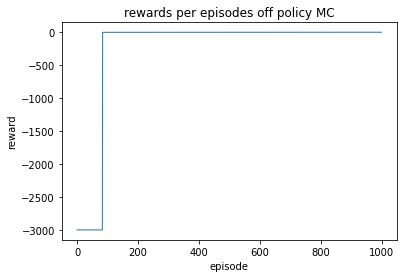

In [123]:
plot_rewards(mc_off_policy_rewards, 'off policy MC')
print('time elapsed: {}'.format(off_policy_time))

all_rewards['off policy mc'] = mc_off_policy_rewards
all_times['off policy mc'] = off_policy_time

As it was mentioned in the class, we used the on-policy mc as the behavior policy and fed that into the off-policy mc. As a result you can see that the observed rewards are as good as they could be from the start. That is because of the almost flawless behavior policy we are using. Because of that, we do not include the results of this part into our comparisons. But to justify the results, the __off policy MC__ aims to explore the environment and exploit it at the same time using two different policies. As you can see in the above plot, more intelligent the behavior policy, more intelligent the agent gets with exploiting the target policy.

Double Q-learning

In [124]:
starting_alpha = .01
alpha = starting_alpha
starting_epsilon = .01
epsilon = starting_epsilon
q1 = np.zeros(shape=(env.nS, env.nA))
q2 = np.zeros(shape=(env.nS, env.nA))
double_qlearning_rewards = []
num_episodes = 1000
starting_time = time.time()
for i in range(num_episodes):
    episode_rewards = 0
    env.reset()
    s = np.argmax(env.isd)
    while True:
        totalQ = q1 + q2
        a, probs = e_greedy(s, totalQ)
        next_s, r, done, info = env.step(a)
        episode_rewards += r
        if np.random.rand() < .5:
            q1[s][a] += alpha*(r + discount_factor*q2[next_s][np.argmax(q1[next_s])] - q1[s][a])
        else:
            q2[s][a] += alpha*(r + discount_factor*q1[next_s][np.argmax(q2[next_s])] - q2[s][a])
        s = next_s
        if r == 1:
            double_qlearning_rewards.append(episode_rewards)
            break
    if i%10 == 0:
        epsilon -= starting_epsilon / 101
        alpha -= starting_alpha / 101
        print("\rEpisode {}/{}.".format(i, num_episodes), end="")
        sys.stdout.flush()
end_time = time.time()
double_qlearning_time = end_time - starting_time

Episode 990/1000.

time elapsed: 10.909246921539307


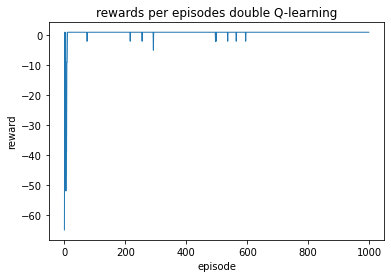

In [125]:
plot_rewards(double_qlearning_rewards, 'double Q-learning')
print('time elapsed: {}'.format(double_qlearning_time))
all_rewards['double Q-learning'] = double_qlearning_rewards
all_times['double Q-learning'] = double_qlearning_time

As you can see in this mode of agent learning the policy, because of removing the barrier of getting to the beach, the agent is starting to learn how to get the most out of environment and as a result of that the convergence is to the y of `1000`. Also you can observe that because of learning step by step, the `double Q-learning` can prevent any punishment. 

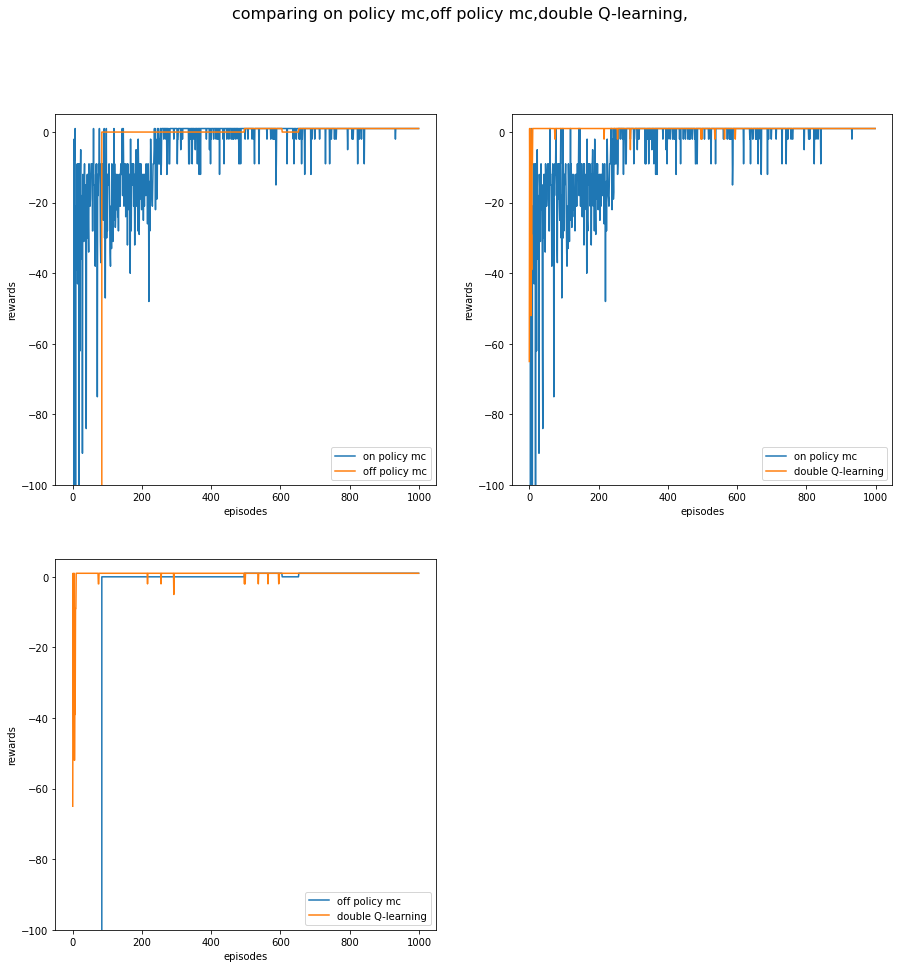

In [126]:
plot_all_rewards(minimum=-100)

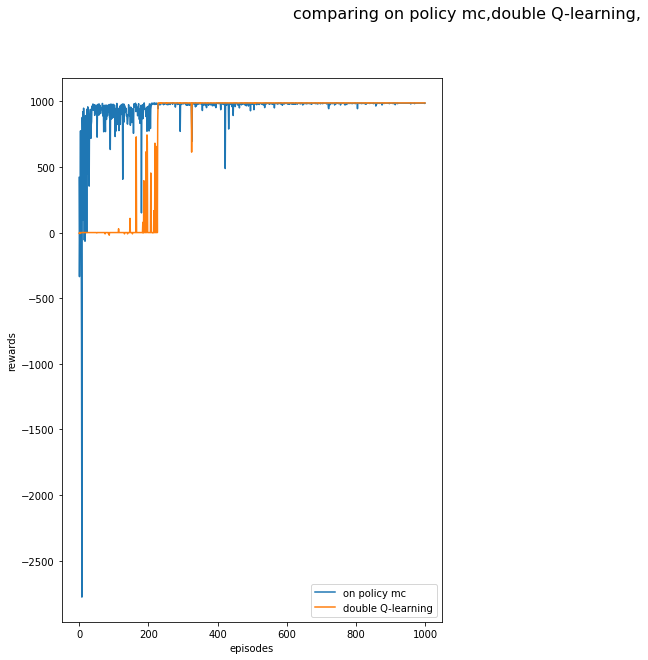

In [33]:
plot_all_rewards()

Tree backup 

In [127]:
alpha = 0.1
epsilon = 0.8
discount_factor = 1
num_episodes = 1000
q = np.zeros(shape=(env.nS, env.nA))

tree_backup_rewards = []
starting_time = time.time()
for i in range(num_episodes):
    env.reset()
    s = np.argmax(env.isd)
    episode_rewards = []
    while True:
        action, _ = softmax(s, q)
        next_s, reward, done, info = env.step(action)
        episode_rewards.append(reward)
        q[s][action] = reward
        _, probs = softmax(next_s, q)
        expected_return = 0
        for a in range(env.nA):
            if a != action:
                expected_return += probs[a] * q[next_s][a]
        q[s][action] += discount_factor * expected_return
        
        if reward == 1:
            break

        s = next_s
    tree_backup_rewards.append(sum(episode_rewards))
    if i % 10 == 0:
        print("\rEpisode {}/{}.".format(i, num_episodes), end="")
        sys.stdout.flush()
end_time = time.time()
tree_backup_time = end_time - starting_time

Episode 990/1000.

In [128]:
def choose_action_softmax(q_values, temperature = 100000):
    denom = np.sum(np.exp(q_values / temperature))
    return np.argmax(np.exp(q_values / temperature) / denom)

In [141]:
def n_step_tree_backup(n):
    discount_factor = 1.0
    starting_epsilon = .8
    epsilon = starting_epsilon
    starting_alpha = 1.0
    alpha = starting_alpha
    num_episodes = 1000
    q = np.zeros((env.nS, env.nA))
    policy = np.ones((env.nS, env.nA)) * epsilon/env.nA
    for s,a in enumerate(np.argmax(q, axis=1)) :
        policy[s,a] += 1-epsilon

    cum_rewards = []
    starting_time = time.time()
    for i_episode in range(1, num_episodes + 1):

        if i_episode%10 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            epsilon -= starting_epsilon / 101
            alpha -= starting_alpha / 101

        env.reset()
        total_reward = 0
        S, A,R = list(),list(),[0]
        S.append(env.s)
#         A.append(np.random.choice(env.nA, p=policy[S[-1]]))
        A.append(choose_action_softmax(policy[S[-1]]))
        T = np.inf
        t = 0
        tou = 0
        while tou + 1 < T :
            if t < T :
                next_s, next_r, done, _ = env.step(A[-1])
                next_r -= 1
                total_reward += next_r
                S.append(next_s)
                R.append(next_r)
                if done :
                    T = t + 1
                else :
#                     A.append(np.random.choice(env.nA, p=policy[S[-1]]))
                    A.append(choose_action_softmax(policy[S[-1]]))
            tou = t - n + 1
            if tou >= 0 :
                if t + 1 >= T:
                    G = R[T]
                else:
                    G = R[t+1] + discount_factor*(np.sum(policy[S[t + 1],:] * q[S[t+1]]))
                for k in range(min(t,T-1), tou, -1) :
                    G = R[k] + \
                    discount_factor * (np.sum(np.delete(policy[S[k]], A[k]) * np.delete(q[S[k]], A[k]))) + \
                    discount_factor * policy[S[k], A[k]] * G
                q[S[tou], A[tou]] += alpha * (G - q[S[tou], A[tou]])
                policy[S[tou]] = epsilon/env.nA
                policy[S[tou],np.argmax(q[S[tou]])] += 1-epsilon
            t += 1
        cum_rewards.append(total_reward + 11)
        end_time = time.time()
        elapsed_time = end_time - starting_time
    return cum_rewards, elapsed_time
    
one_step_tree_backup_rewards, one_step_tree_backup_time = n_step_tree_backup(n=1)
two_step_tree_backup_rewards, two_step_tree_backup_time = n_step_tree_backup(n=2)
three_step_tree_backup_rewards, three_step_tree_backup_time = n_step_tree_backup(n=3)

Episode 1000/1000.

As you can see in the above charts depicting the performance of tree back up with different n's, we can conclude that all n's perform in the same way. That could be because of the tree backup itself and that this algorithm with large values of n are not compatible with the problem in hand to help the agent perform better. Another reason might be the number of episodes because as it has been proved in the book, all tree back up methods with different values of n should converge to the same policy and q-values, and also because of the hyper-parameters we have like epsilon and alpha. After saying all these, `we can see than with different values of n, convergence to the optimum policy would be a certain outcome.` Because of that, we will compare other algorithms with the `first-step-tree-backup`.

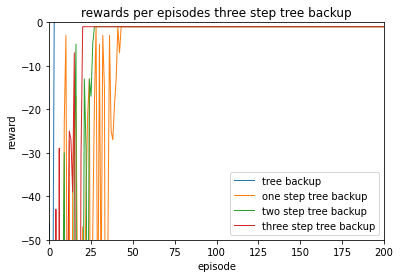

In [143]:
plot_rewards(tree_backup_rewards, 'tree backup')
plot_rewards(one_step_tree_backup_rewards, 'one step tree backup')
plot_rewards(two_step_tree_backup_rewards, 'two step tree backup')
plot_rewards(three_step_tree_backup_rewards, 'three step tree backup')
plt.legend(loc='lower right')
plt.ylim(-50, 0)
plt.xlim(0, 200)
all_rewards['tree backup'] = tree_backup_rewards
# all_rewards['two step tree backup'] = two_step_tree_backup_rewards
# all_rewards['three step tree backup'] = three_step_tree_backup_rewards
# all_rewards['one step tree backup'] = one_step_tree_backup_rewards
all_times['two step tree backup'] = two_step_tree_backup_time
all_times['three step tree backup'] = three_step_tree_backup_time
all_times['one step tree backup'] = one_step_tree_backup_time
all_times['tree backup'] = tree_backup_time

By comparing different algorithms and approach for carrying out the `tree back up` with different values of n, all of them perform well and equally for all n's. but overally, we can see that there is a slight difference between higher values of n in that higher values of n converge sooner than the lower values of n. That can be accounted for by the fact that higher values of n have access to more information for updating their weights.

letting the agents wander after reaching the beach too.

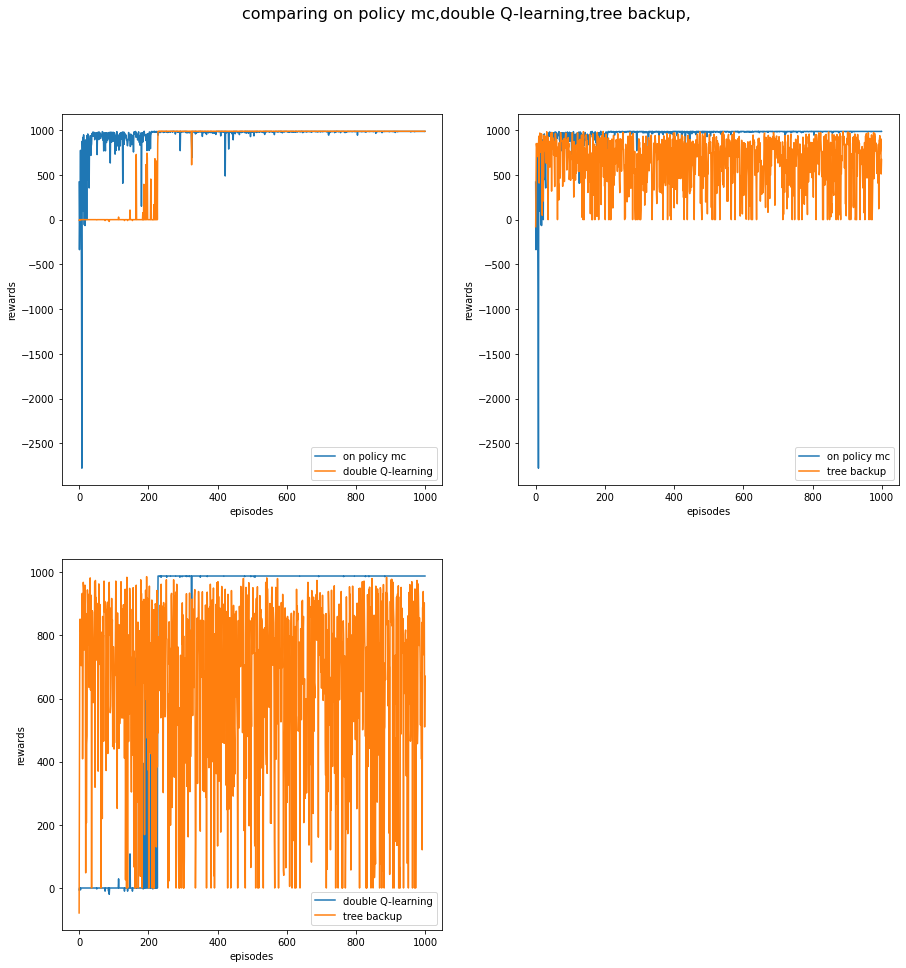

In [39]:
plot_all_rewards()

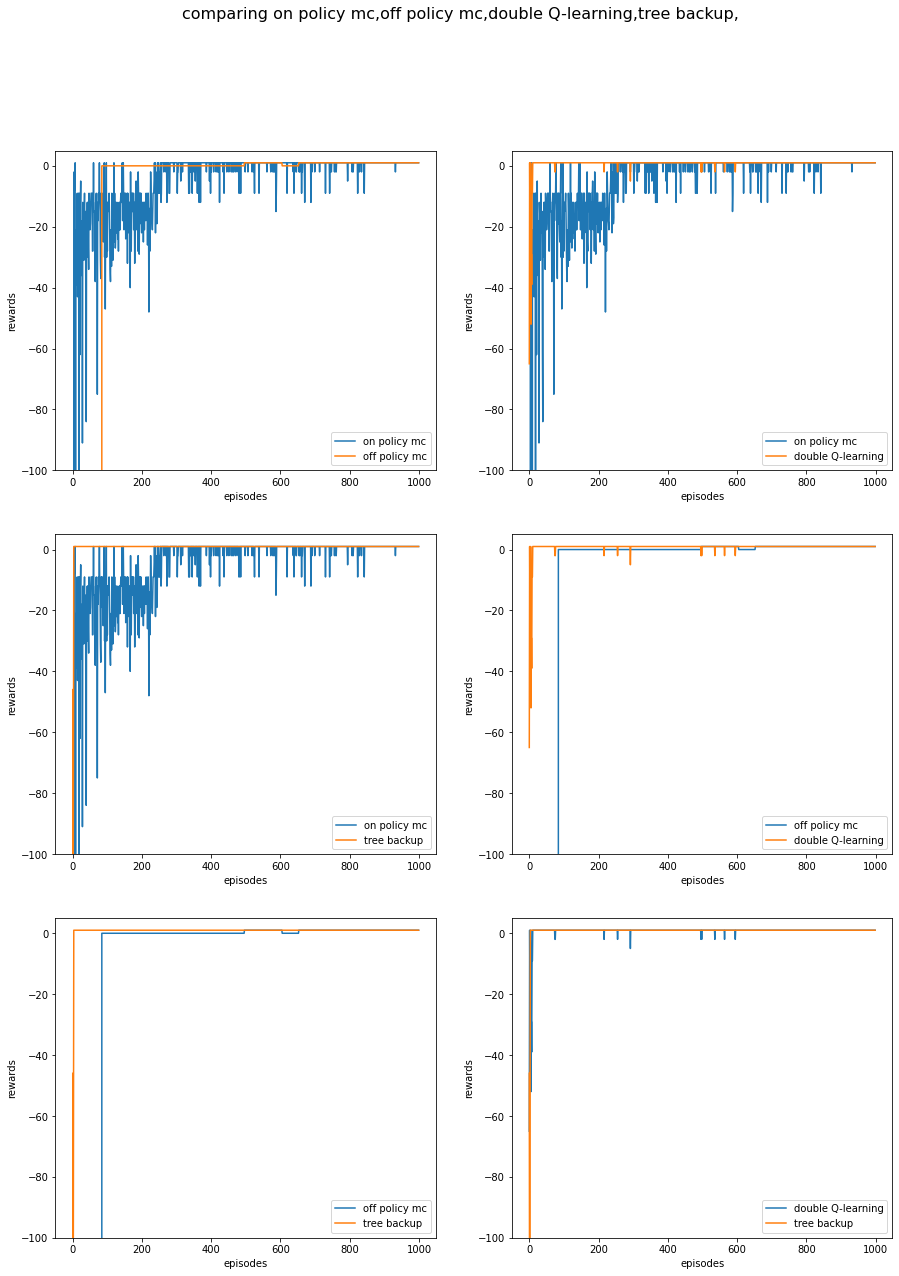

In [149]:
plot_all_rewards(minimum=-100)

__Bonus part__

As you can see in the below picture, comparing two different modes with the right charts having higher rewards reaching the island, their speed of convergence is slightly higher.

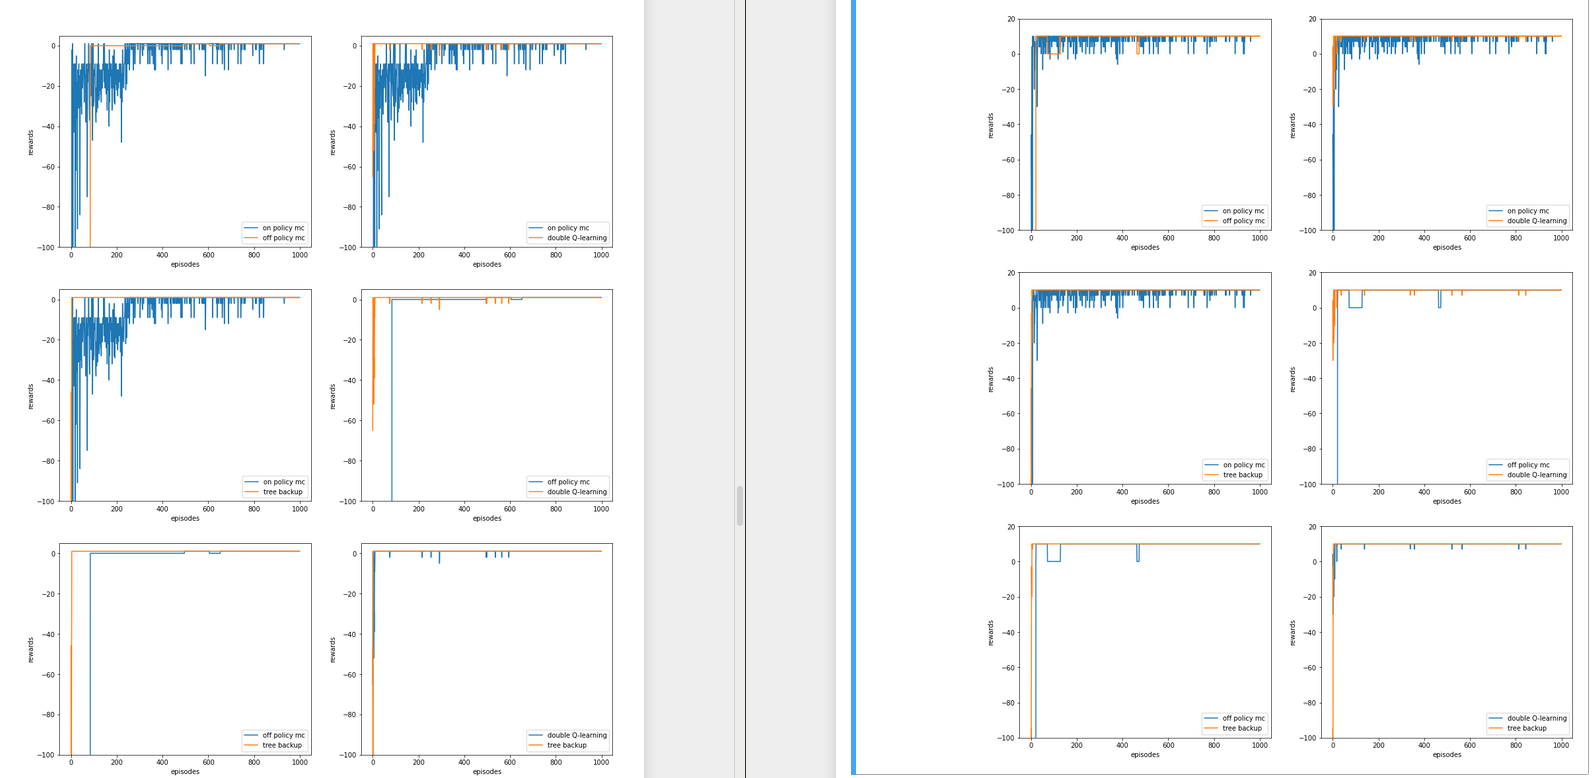


Sarsa

In [150]:
starting_alpha = .6
alpha = starting_alpha
starting_epsilon = .4
epsilon = starting_epsilon
discount_factor = 1.
num_episodes = 1000
q = np.zeros(shape=(env.nS, env.nA))
sarsa_rewards = []
starting_time = time.time()
for i in range(num_episodes):
    env.reset()
    episode_rewards = 0
    s = np.argmax(env.isd)
    a, probs = softmax(s, q, .9)
    while True:
        next_s, r, done, info = env.step(a)
        episode_rewards += r
        next_a, probs = softmax(next_s, q, .9)
        q[s][a] += alpha*(r + discount_factor*q[next_s][next_a] - q[s][a])
        s = next_s
        a = next_a
        if r == 1:
            sarsa_rewards.append(episode_rewards)
            break
    if i%10 == 0:
        epsilon -= starting_epsilon / 101
        alpha -= starting_alpha / 101
        print("\rEpisode {}/{}.".format(i, num_episodes), end="")
        sys.stdout.flush()
end_time = time.time()
sarsa_time = end_time - starting_time

Episode 990/1000.

time elapsed: 2.282487154006958


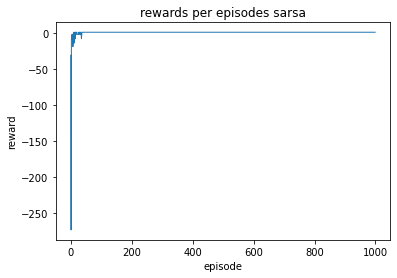

In [151]:
plot_rewards(sarsa_rewards, 'sarsa')
print('time elapsed: {}'.format(sarsa_time))
all_rewards['sarsa'] = sarsa_rewards
all_times['sarsa'] = sarsa_time

letting the agent wander after reaching the beach.

time elapsed: 74.71876955032349


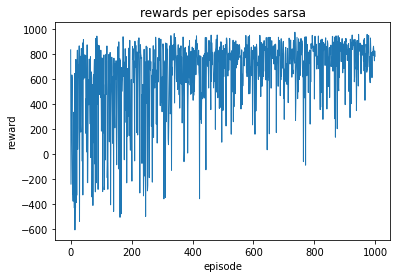

In [115]:
plot_rewards(sarsa_rewards, 'sarsa')
print('time elapsed: {}'.format(sarsa_time))
all_rewards['sarsa'] = sarsa_rewards
all_times['sarsa'] = sarsa_time

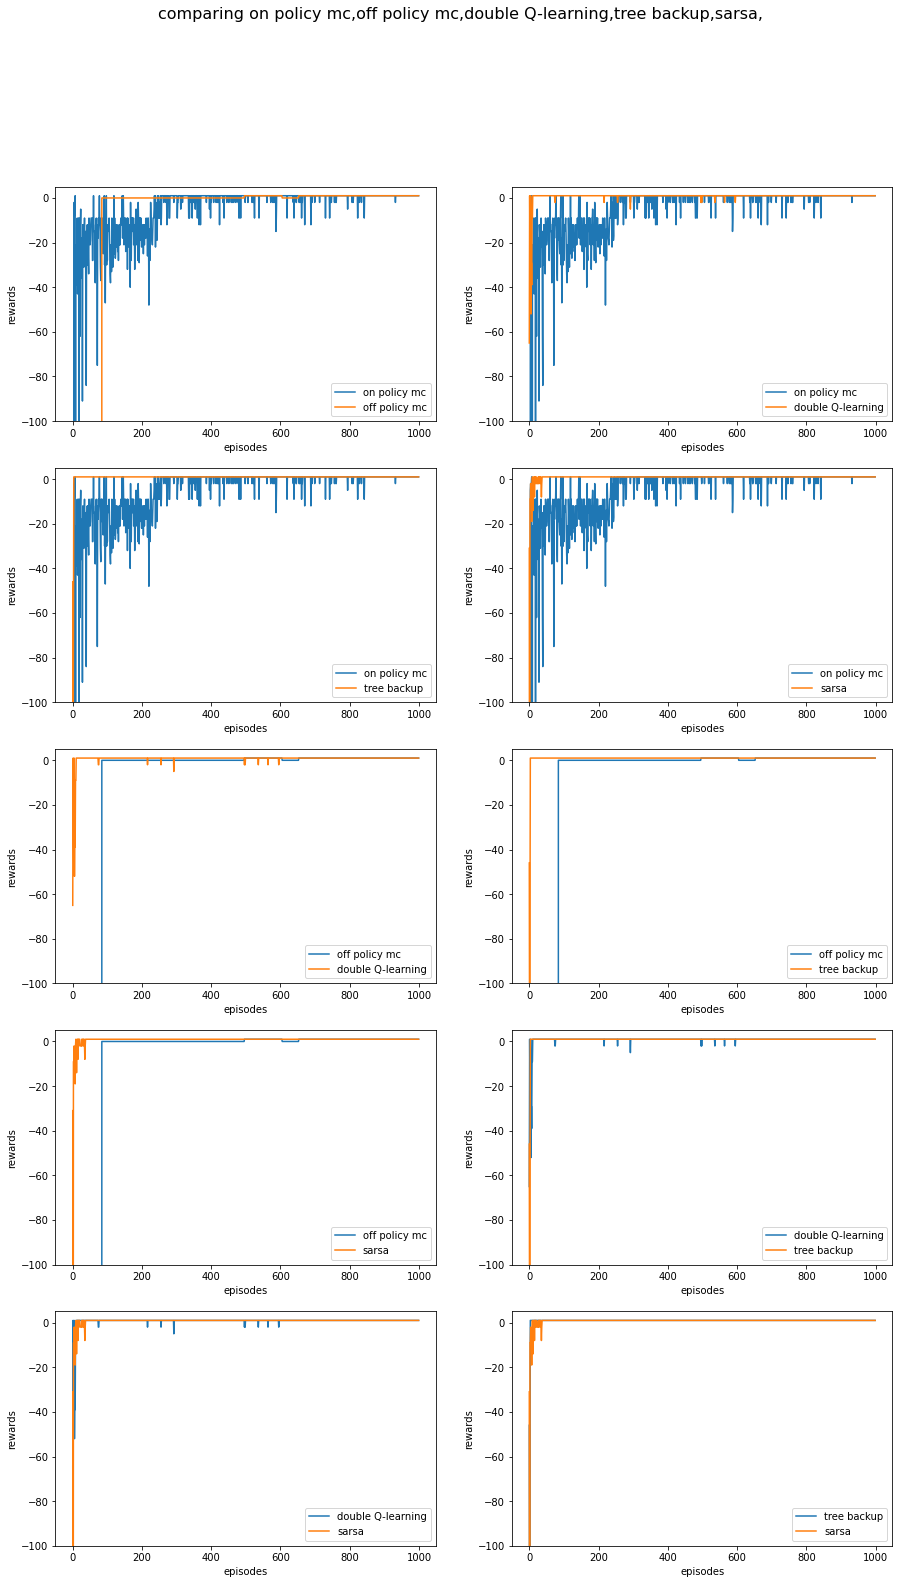

In [153]:
plot_all_rewards(minimum=-100)

two-step expected sarsa

In [154]:
starting_alpha = .4
starting_epsilon = .7
alpha = starting_alpha
epsilon = starting_epsilon
discount_factor = 1.
q = np.zeros(shape=(env.nS, env.nA))
expected_sarsa_rewards = []
starting_time = time.time()
num_episodes = 1000
for i in range(num_episodes):
    env.reset()
    episode_rewards = 0
    s = np.argmax(env.isd)
    a, probs = softmax(s, q)
    while True:
        next_s, r, done, info = env.step(a)
        episode_rewards += r
        if r == 1:
            expected_sarsa_rewards.append(episode_rewards)
            break
        next_a, probs = softmax(next_s, q)
        expected_following_return = 0
        for action in range(env.nA):
            expected_following_return += probs[action]*q[next_s][action]
        q[s][a] += alpha*(r + discount_factor*expected_following_return - q[s][a])
        s = next_s
        a = next_a
    if i%10 == 0:
        epsilon -= starting_epsilon / 101
        alpha -= starting_alpha / 101
        print("\rEpisode {}/{}.".format(i, num_episodes), end="")
        sys.stdout.flush()
end_time = time.time()
expected_sarsa_time = end_time - starting_time

Episode 990/1000.

time elapsed: 52.81602096557617


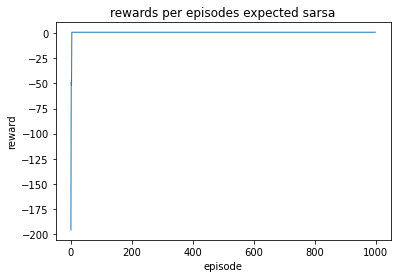

In [155]:
plot_rewards(expected_sarsa_rewards, 'expected sarsa')
print('time elapsed: {}'.format(expected_sarsa_time))
all_rewards['expected sarsa'] = expected_sarsa_rewards
all_times['expected sarsa'] = expected_sarsa_time

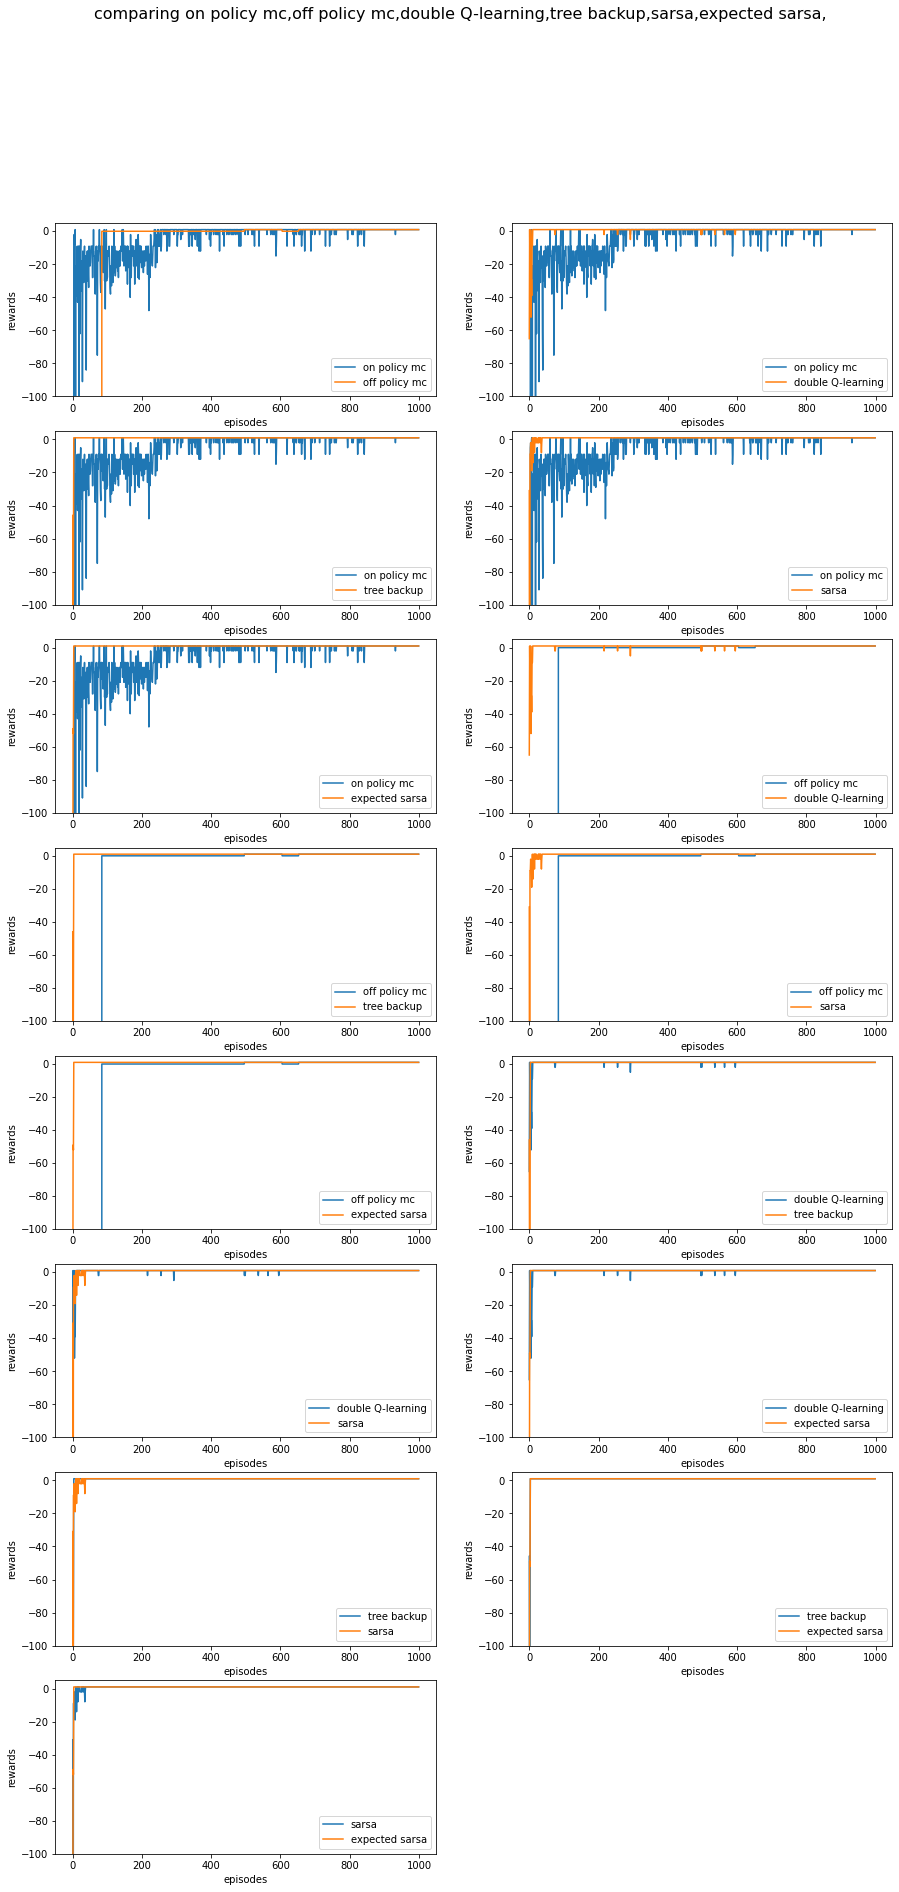

In [156]:
plot_all_rewards(minimum=-100)

###### Comparing different methods' results

As we can see, the __on policy MC__ act poorly in terms of the speed of convergence to the optimum policy and choosing actions with no punishments. Than can be justified due to the low sampling efficiency of this method. As it generates a full episode regardless of its efficacy and it can just exploit the observed rewards from the trajectory of states, actions, and rewards, the speed of convergence and also the following punishments are notably more than the other ones.

---

__double Q-learning__ has a performance roughly as good as sarsa, expected sarsa, tree backup. This is due to the fact that all these methods incorporate the q-values of actions and states surrounding the actual state and also updates per steps. As The double Q-learning is a `off-policy` method and also it prevents maximization bias, this method is capable of early coverage and also the least early punishments among its counterparts. While two different sets of q-values aids the agent to avoid punishments and get to the destined point earlier, this makes it prune to some unreasonable decisions afterwards where the agent gets extreme punishments. The worthy thing to mention is that all the difference between this method and `sarsa` or `expected sarsa` is because of the `max` function that embraces the following states and actions. This results in less punishments but more punishments afterwards.

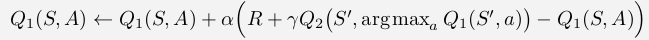

--- 

__Sarsa__ can be seen as the less-mature version of `expected sarsa`, `tree backup`, and `double Q-learning`. As it uses each step to update its estimation of q-values, it can outperform `on-policy MC`, but the act that it's more myopic than the the other mentioned ones, it get longer for it to get rid of its fluctuations. More precisely, that is becaues of the fact that other methods incorporate all the q-values preceded by the current state and not just one of them. This results in a more far-sighted acting, less punishments, and early convergence consequently. The aforementioned justifications can be proved by the charts shown above as the sarsa fluctuates a little bit more after convergence of its superiors and converges subsequently.

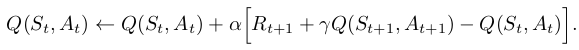

---

__Expected Sarsa__ is conspicuously better than `sarsa` because it does take advantage of all the q-values that could be chosen afterwards. This learning algorithm is just like Q-learning except that instead of the maximum over next state–action pairs it uses the expected value, taking into account how likely each action is under the current policy. `Expected Sarsa` is more complex than Sarsa but, in return, it eliminates teh variance due to the random selection of next states. Given the same amount of experience we might expect it to perform slightly better than Sarsa, and indeed it generally does.


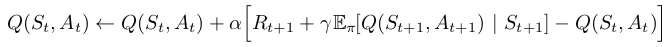

---

The __tree backup__ can be seen as the expanded version of `sarsa` and `expected sarsa` in that it can perform like off policy learning algorithm without importance sampling and exploiting the pair of state-actions of both chosen and non-chosen actions each state down through the preceding states. In our case, we implemented the 1-step tree backup and because of that it bears a resemblance to the aforementioned learning algorithms. All the properties and advantages that are gained from sarsa and expected sarsa are true for this algorithm too. 

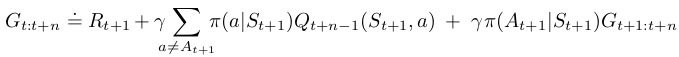

__Bonus part__

As you can see except for the sarsa, all other algorithms peform better and converge sooner with higher rewards for reaching the beach.

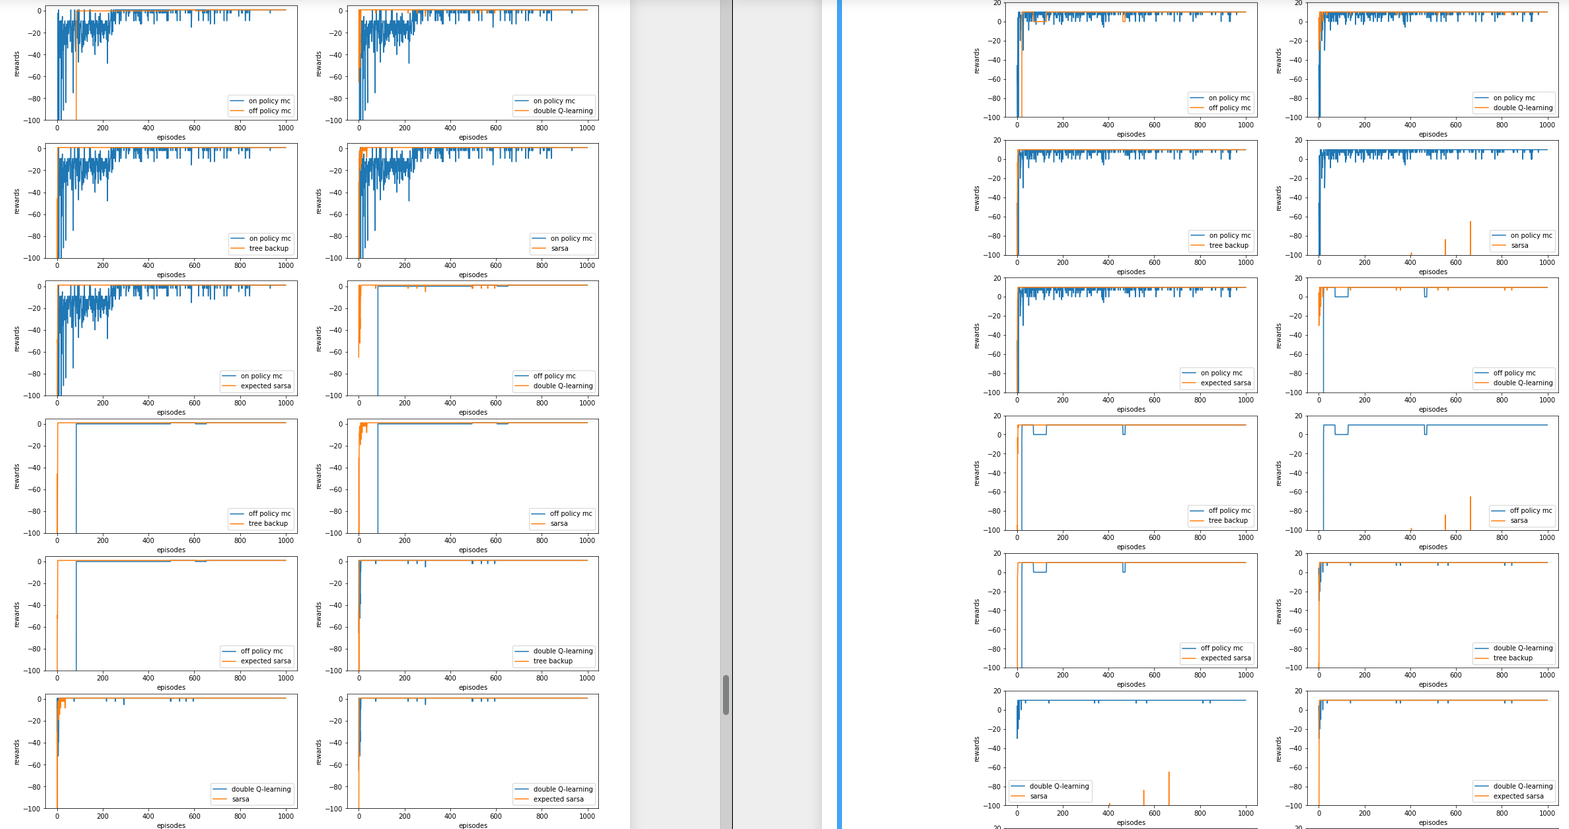

Although the speed of convergence entails on adjusting alpha (learning rate), epsilon and other hyper-parameters, the role of reward can become important in that the agent puts more worth on reaching the island sooner because after that the rewards will be more. This way, the agent would find the best, shortest path possible to get to the island and get the maximum reward it can gather.

(-50.0, 5.0)

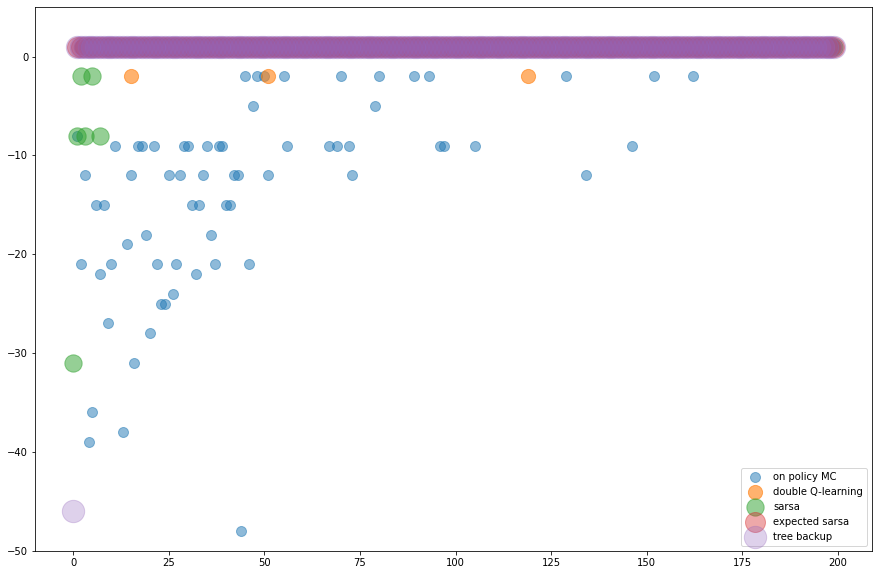

In [159]:
plt.figure(figsize=(15, 10))
plt.scatter(np.arange(200), on_policy_mc_rewards[::5], label='on policy MC', s=100, alpha=.5)
plt.scatter(np.arange(200), double_qlearning_rewards[::5], label='double Q-learning', s=200, alpha=.6)
plt.scatter(np.arange(200), sarsa_rewards[::5], label='sarsa', s=300, alpha=.5)
plt.scatter(np.arange(200), expected_sarsa_rewards[::5], label='expected sarsa', s=400, alpha=0.4)
plt.scatter(np.arange(200), tree_backup_rewards[::5], label='tree backup', s=500, alpha = .3)
plt.legend(markerscale=1)
plt.ylim(-50, 5)

Text(0.5, 1.0, 'time elapsed for each mode')

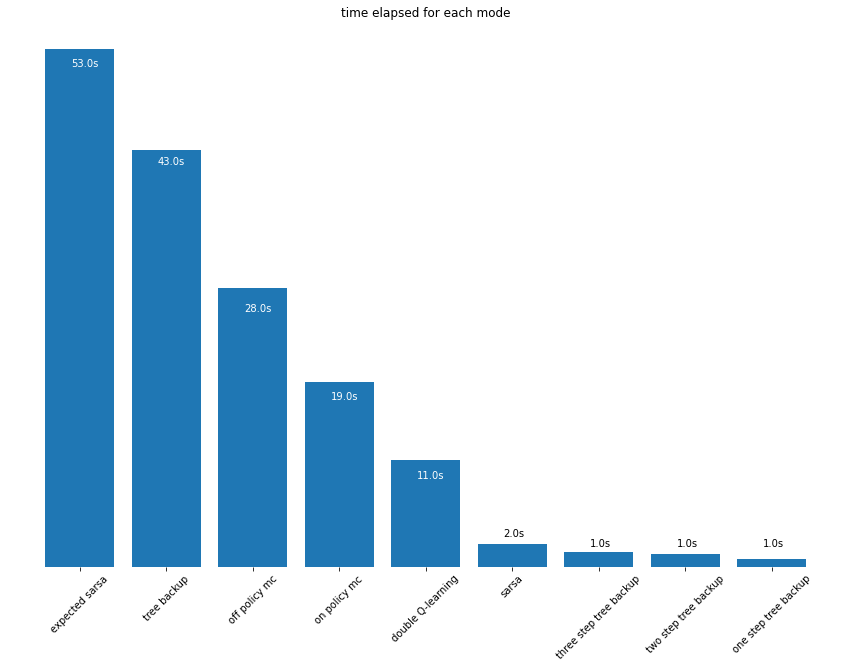

In [163]:
all_times = {k: v for k, v in sorted(all_times.items(), key=lambda item: item[1], reverse=True)}
fig = plt.figure(figsize=(15, 10))
lines = plt.bar(x=list(all_times.keys()), height=list(all_times.values()))
plt.gca().set_yticks([])
for index, value in enumerate(all_times.values()):
    if value < 5:
        plt.annotate(str(np.round(value)) + 's', (index - .1, np.round(value) + 1))
    else:
        plt.annotate(str(np.round(value)) + 's', (index - .1, np.round(value) - 2), color='white')
# plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.xticks(rotation=45)
plt.title('time elapsed for each mode')

As you can see, due to the computational cost that `expected sarsa` and `tree backup` both impose to us, the time took for the `expected sarsa` and `tree backup` are longer than the others. Besides, the simple concept of `sarsa` makes it converge sooner than the others as we described in the preceding parts. The notably little time it takes for `double Q-learning` to converge is due to the avoidance of maximization bias and also the `max` function that embrace the control unit. It helps the algorithm to run much faster than the others. Another important part of these charts is that the tree back up different implementations can have great impact on their execution time. `one to three step tree back up` times are better than all other algorithms because they take advantage of the q-values of all the available actions when updating the q-values. This way, they find the best path and continue to choose that path with no delay. `It is worth noting that all these timings are considerably better with the aid of softmax unit for choosing actions, while e-greedy unit adds up to their execution time.`